# Data 80:20

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from google.colab import drive
import random


In [2]:
# Mount Google Drive (uncomment jika diperlukan untuk Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Configuration variables
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.00001

In [4]:
# Tetapkan seed global
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Tetapkan seed
set_seed(42)

In [5]:
# Konfigurasi path data
DATA_DIR = '/content/drive/MyDrive/TA'  # direktori utama dataset
KARIES_DIR = os.path.join(DATA_DIR, 'database2/karies')  # direktori gambar karies
SEHAT_DIR = os.path.join(DATA_DIR, 'database2/sehat')   # direktori gambar sehat
PROCESSED_DIR = os.path.join(DATA_DIR, 'dt2/individual')  # direktori hasil preprocessing

In [6]:
# ===== AWAL PEMERIKSAAN DATA =====
# Memeriksa jumlah gambar di setiap folder
jumlah_karies = len(os.listdir(KARIES_DIR))
jumlah_sehat = len(os.listdir(SEHAT_DIR))

print(f"Jumlah gambar karies: {jumlah_karies}")
print(f"Jumlah gambar sehat: {jumlah_sehat}")

Jumlah gambar karies: 244
Jumlah gambar sehat: 381


#Preprocessing Gambar

In [ ]:
def preprocess_image(img_path, output_path=None, denoise=True, clahe=True, save=False):
    """
    Fungsi untuk preprocessing gambar panoramik gigi

    Parameters:
    - img_path: Path ke gambar input
    - output_path: Path untuk menyimpan gambar hasil preprocessing (opsional)
    - denoise: Apakah menerapkan denoising
    - clahe: Apakah menerapkan Contrast Limited Adaptive Histogram Equalization
    - save: Apakah menyimpan hasil preprocessing

    Returns:
    - img_processed: Gambar yang telah diproses
    """
    # Baca gambar
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Tidak dapat membaca gambar dari {img_path}")
        return None

    # Konversi ke grayscale jika gambar berwarna
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Menerapkan denoising untuk mengurangi noise
    if denoise:
        img_gray = cv2.fastNlMeansDenoising(img_gray, None, 10, 7, 21)

    # Menerapkan CLAHE untuk meningkatkan kontras
    if clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_processed = clahe.apply(img_gray)
    else:
        img_processed = img_gray

    # Menyimpan hasil preprocessing jika diperlukan
    if save and output_path:
        cv2.imwrite(output_path, img_processed)

    return img_processed

In [ ]:
# Fungsi untuk preprocessing batch gambar (dapat dijalankan secara opsional)
def batch_preprocess(input_dir, output_dir):
    """
    Memproses semua gambar dalam direktori dan menyimpan hasil
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(input_dir)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            preprocess_image(input_path, output_path, save=True)
            print(f"Preprocessed: {file}")


In [ ]:
# CATATAN: Uncomment baris di bawah jika ingin melakukan preprocessing manual
batch_preprocess(KARIES_DIR, os.path.join(PROCESSED_DIR, 'processed_karies'))
batch_preprocess(SEHAT_DIR, os.path.join(PROCESSED_DIR, 'processed_sehat'))

Preprocessed: 20250507_145913.jpg
Preprocessed: 161.jpg
Preprocessed: 436.jpg
Preprocessed: 354.jpg
Preprocessed: 182.jpg
Preprocessed: 278.jpg
Preprocessed: 408.jpg
Preprocessed: 13.jpg
Preprocessed: 476.jpg
Preprocessed: 515.jpg
Preprocessed: 579.jpg
Preprocessed: 522.jpg
Preprocessed: 173.jpg
Preprocessed: 384.jpg
Preprocessed: 434.jpg
Preprocessed: 297.jpg
Preprocessed: 43.jpg
Preprocessed: 115.jpg
Preprocessed: 584.jpg
Preprocessed: 6.jpg
Preprocessed: 20250507_153128.jpg
Preprocessed: 551.jpg
Preprocessed: 572.jpg
Preprocessed: 375.jpg
Preprocessed: 192.jpg
Preprocessed: 20250507_153334.jpg
Preprocessed: 335.jpg
Preprocessed: 273.jpg
Preprocessed: 327.jpg
Preprocessed: 191.jpg
Preprocessed: 556.jpg
Preprocessed: 489.jpg
Preprocessed: 292.jpg
Preprocessed: 235.jpg
Preprocessed: 225.jpg
Preprocessed: 308.jpg
Preprocessed: 211.jpg
Preprocessed: 402.jpg
Preprocessed: 20250507_154131.jpg
Preprocessed: 20250507_154117.jpg
Preprocessed: 506.jpg
Preprocessed: 323.jpg
Preprocessed: 202505

#Preprocessing Data

In [7]:
# ===== BAGIAN PRE-PROCESSING DATA =====
# Membuat generator data dengan augmentasi untuk data training
# Preprocessing meliputi:
# 1. Rescaling - Normalisasi nilai piksel dari 0-255 menjadi 0-1
# 2. Augmentasi data - Meningkatkan variasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.2,  # 20% data untuk validasi
    rotation_range=20,  # Rotasi gambar hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi shear
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Refleksi horizontal
    fill_mode='nearest',  # Strategi mengisi piksel baru
    # brightness_range=[0.8, 1.2]  # Variasi kecerahan (opsional untuk menangani kontras berbeda)
)


In [8]:
# Generator untuk data validasi (hanya rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.2  # 20% data untuk validasi
)

In [9]:
# Memuat data dan menerapkan preprocessing
# target_size - Mengubah ukuran semua gambar menjadi 224x224 piksel (preprocessing ukuran)
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Klasifikasi biner: karies atau sehat
    subset='training',
    shuffle=True,  # Mengacak data untuk training
    seed=42
)

# Memuat data validasi
validation_generator = validation_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Tidak mengacak data validasi
    seed=42
)


Found 501 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


# Building Model

In [10]:
# Membangun model CNN
model = models.Sequential([
    # Layer konvolusi pertama
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi kedua
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi ketiga
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi keempat
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer flatten untuk mengubah menjadi format 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Layer output
    layers.Dense(1, activation='sigmoid')  # sigmoid untuk klasifikasi biner
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
tf.keras.utils.set_random_seed(42)

In [13]:
# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
# Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [15]:
# Menyimpan model terbaik
checkpoint_filepath = '/content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [16]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5159 - loss: 1.0167
Epoch 1: val_accuracy improved from -inf to 0.38710, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 197s 12s/step - accuracy: 0.5176 - loss: 1.0132 - val_accuracy: 0.3871 - val_loss: 0.6952
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5898 - loss: 0.8258
Epoch 2: val_accuracy improved from 0.38710 to 0.40323, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.5902 - loss: 0.8243 - val_accuracy: 0.4032 - val_loss: 0.6940
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5934 - loss: 0.7782
Epoch 3: val_accuracy improved from 0.40323 to 0.61290, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.5948 - loss: 0.7777 - val_accuracy: 0.6129 - val_loss: 0.6885
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6126 - loss: 0.7661
Epoch 4: val_accuracy did not improve from 0.61290
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.6128 - loss: 0.7649 - val_accuracy: 0.3871 - val_loss: 0.6980
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6481 - loss: 0.7030
Epoch 5: val_accuracy did not improve from 0.61290
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.6482 - loss: 0.7016 - val_accuracy: 0.6129 - val_loss: 0.6840
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6329 - loss: 0.6864
Epoch 6: val_accuracy did not improve from 0.61290
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.6335 - loss: 0.6867 - val_accuracy: 0.6129 - val_loss: 0.6785
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6820 - loss: 0.6356
Epoch 7: val_accuracy did not improve from 0.61290
16/1

16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.7342 - loss: 0.5631 - val_accuracy: 0.6210 - val_loss: 0.7102
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6934 - loss: 0.6227
Epoch 26: val_accuracy did not improve from 0.62097
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.6937 - loss: 0.6224 - val_accuracy: 0.6210 - val_loss: 0.7160
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7135 - loss: 0.5680
Epoch 27: val_accuracy did not improve from 0.62097
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7134 - loss: 0.5690 - val_accuracy: 0.6129 - val_loss: 0.7179
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7048 - loss: 0.5862
Epoch 28: val_accuracy did not improve from 0.62097
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7059 - loss: 0.5851 - val_accuracy: 0.6129 - val_loss: 0.7935
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7345 - loss: 0.5546
Epoch 29: val_accuracy did not improve from 0.62

16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7505 - loss: 0.5391 - val_accuracy: 0.6290 - val_loss: 0.6665
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6947 - loss: 0.5863
Epoch 33: val_accuracy did not improve from 0.62903
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.6959 - loss: 0.5847 - val_accuracy: 0.6290 - val_loss: 0.6562
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7103 - loss: 0.5638
Epoch 34: val_accuracy improved from 0.62903 to 0.64516, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.7104 - loss: 0.5636 - val_accuracy: 0.6452 - val_loss: 0.6431
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7899 - loss: 0.4793
Epoch 35: val_accuracy did not improve from 0.64516
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.7879 - loss: 0.4815 - val_accuracy: 0.6452 - val_loss: 0.6297
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7137 - loss: 0.5900
Epoch 36: val_accuracy improved from 0.64516 to 0.69355, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.7148 - loss: 0.5888 - val_accuracy: 0.6935 - val_loss: 0.5758
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7615 - loss: 0.5208
Epoch 37: val_accuracy improved from 0.69355 to 0.70968, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7604 - loss: 0.5226 - val_accuracy: 0.7097 - val_loss: 0.5819
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7588 - loss: 0.4958
Epoch 38: val_accuracy did not improve from 0.70968
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7578 - loss: 0.4978 - val_accuracy: 0.7016 - val_loss: 0.6019
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7320 - loss: 0.6024
Epoch 39: val_accuracy did not improve from 0.70968
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7321 - loss: 0.6017 - val_accuracy: 0.7097 - val_loss: 0.5625
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7282 - loss: 0.5665
Epoch 40: val_accuracy improved from 0.70968 to 0.71774, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.7290 - loss: 0.5648 - val_accuracy: 0.7177 - val_loss: 0.5518
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7259 - loss: 0.5367
Epoch 41: val_accuracy improved from 0.71774 to 0.74194, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.7259 - loss: 0.5368 - val_accuracy: 0.7419 - val_loss: 0.5337
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7409 - loss: 0.5482
Epoch 42: val_accuracy did not improve from 0.74194
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.7414 - loss: 0.5459 - val_accuracy: 0.7258 - val_loss: 0.5358
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7230 - loss: 0.5449
Epoch 43: val_accuracy did not improve from 0.74194
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7234 - loss: 0.5458 - val_accuracy: 0.7419 - val_loss: 0.4937
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7443 - loss: 0.5648
Epoch 44: val_accuracy improved from 0.74194 to 0.75000, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7435 - loss: 0.5648 - val_accuracy: 0.7500 - val_loss: 0.4892
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7405 - loss: 0.5218
Epoch 45: val_accuracy improved from 0.75000 to 0.76613, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.7407 - loss: 0.5213 - val_accuracy: 0.7661 - val_loss: 0.4874
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7675 - loss: 0.4914
Epoch 46: val_accuracy did not improve from 0.76613
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.7679 - loss: 0.4907 - val_accuracy: 0.7661 - val_loss: 0.4976
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7582 - loss: 0.5195
Epoch 47: val_accuracy improved from 0.76613 to 0.78226, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.7590 - loss: 0.5181 - val_accuracy: 0.7823 - val_loss: 0.4697
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7356 - loss: 0.4798
Epoch 48: val_accuracy improved from 0.78226 to 0.79032, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.7362 - loss: 0.4800 - val_accuracy: 0.7903 - val_loss: 0.4623
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7328 - loss: 0.5902
Epoch 49: val_accuracy improved from 0.79032 to 0.79839, saving model to /content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.7336 - loss: 0.5865 - val_accuracy: 0.7984 - val_loss: 0.4739
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7661 - loss: 0.4955
Epoch 50: val_accuracy did not improve from 0.79839
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.7660 - loss: 0.4967 - val_accuracy: 0.7903 - val_loss: 0.4748


#Evaluation

In [17]:
# Menampilkan hasil terbaik dari training
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_val_acc_idx]
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_epoch = best_val_acc_idx + 1

print("\nHasil Terbaik dari Training:")
print(f"Epoch terbaik: {best_epoch}")
print(f"Akurasi training terbaik: {best_train_acc:.4f}")
print(f"Akurasi validasi terbaik: {best_val_acc:.4f}")


Hasil Terbaik dari Training:
Epoch terbaik: 49
Akurasi training terbaik: 0.7465
Akurasi validasi terbaik: 0.7984


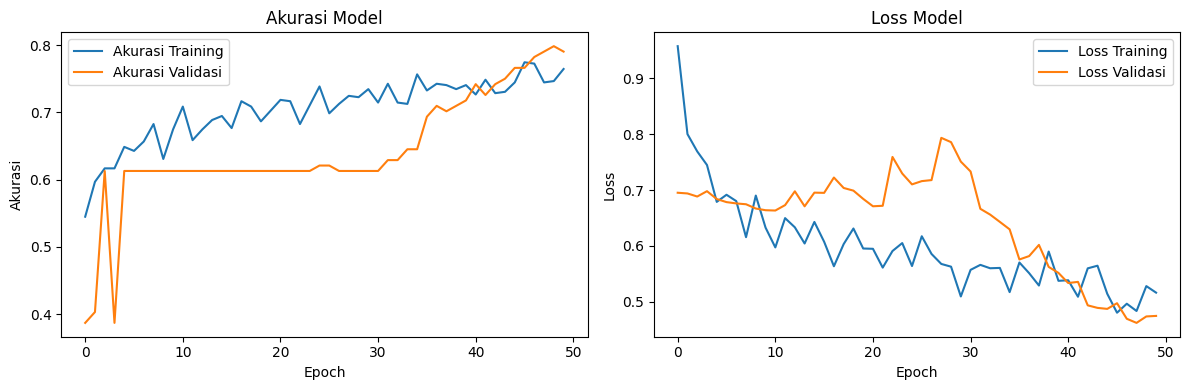

In [18]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TA/database2/hasilta3/training_history.png')
plt.show()

In [19]:
# Evaluasi model pada data validasi
validation_generator.reset()
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 826ms/step


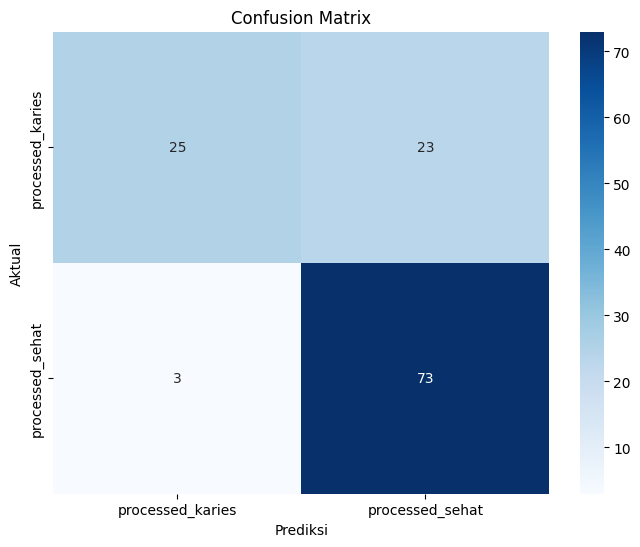

In [20]:
# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.savefig('/content/drive/MyDrive/TA/database2/hasilta3/confusion_matrix.png')
plt.show()

In [21]:
# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys())
))


Laporan Klasifikasi:
                  precision    recall  f1-score   support

processed_karies       0.89      0.52      0.66        48
 processed_sehat       0.76      0.96      0.85        76

        accuracy                           0.79       124
       macro avg       0.83      0.74      0.75       124
    weighted avg       0.81      0.79      0.77       124



In [22]:
# Menyimpan model final
model.save('/content/drive/MyDrive/TA/database2/hasilta3/model_karies_gigi_final.h5')